In [5]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.ensemble import IsolationForest

%matplotlib inline

plt.style.use('seaborn')

df  = pd.read_csv("creditcard.csv")[:80_000]
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [6]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

In [7]:
# start from class_weight on unbalanced data
mod = LogisticRegression(
class_weight={0: 1, 1: 2}, max_iter=1000)
mod.fit(X, y).predict(X).sum()

171

In [8]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

make_scorer(min_recall_precision, greater_is_better=False)

make_scorer(min_recall_precision, greater_is_better=False)

In [9]:
def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'min_both': min_recall_precision}, # why not F1-score ?
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y);

In [16]:
pd.DataFrame(grid.cv_results_)    

# s = make_scorer(min_recall_precision)
# ??s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_contamination,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,13.477373,0.467646,3.459333,0.128582,0.001,{'contamination': 0.001},0.560000,0.666667,0.727273,0.000000,...,0.323541,1,0.383562,0.206897,0.355556,0.000000,0.000000,0.189203,0.165745,10
1,12.994364,0.279210,3.472901,0.102427,0.003111,{'contamination': 0.003111111111111111},0.425532,0.254545,0.625000,0.000000,...,0.211820,2,0.547945,0.482759,0.666667,0.000000,0.300000,0.399474,0.232313,9
2,13.465387,0.287932,3.539688,0.125906,0.005222,{'contamination': 0.005222222222222222},0.336207,0.179487,0.388235,0.066667,...,0.124425,3,0.534247,0.482759,0.733333,0.157895,0.333333,0.448313,0.193582,8
3,13.332475,0.270576,3.308928,0.109428,0.007333,{'contamination': 0.007333333333333333},0.299020,0.112903,0.333333,0.044118,...,0.116847,4,0.835616,0.482759,0.844444,0.157895,0.400000,0.544143,0.264148,7
4,13.185300,0.246203,3.435873,0.186448,0.009444,{'contamination': 0.009444444444444443},0.245833,0.104895,0.250000,0.032258,...,0.086935,5,0.808219,0.517241,0.822222,0.157895,0.466667,0.554449,0.245946,6
5,13.107837,0.423847,3.418752,0.199681,0.011556,{'contamination': 0.011555555555555555},0.215488,0.115183,0.198925,0.023810,...,0.074372,6,0.876712,0.758621,0.822222,0.157895,0.433333,0.609757,0.273449,4
6,12.868651,0.335254,3.367670,0.095503,0.013667,{'contamination': 0.013666666666666667},0.178248,0.100000,0.192308,0.013158,...,0.068899,7,0.808219,0.689655,0.888889,0.105263,0.466667,0.591739,0.281798,5
7,13.105872,0.536870,3.494634,0.095011,0.015778,{'contamination': 0.015777777777777776},0.179063,0.101382,0.161943,0.018634,...,0.060040,8,0.890411,0.758621,0.888889,0.157895,0.600000,0.659163,0.272364,2
8,13.061501,0.238923,3.305577,0.096910,0.017889,{'contamination': 0.017888888888888888},0.146067,0.080321,0.137931,0.014493,...,0.049792,9,0.890411,0.689655,0.888889,0.157895,0.566667,0.638703,0.270152,3
9,10.866226,2.540917,2.687754,0.683640,0.02,{'contamination': 0.02},0.147727,0.079422,0.123867,0.013514,...,0.048100,10,0.890411,0.758621,0.911111,0.157895,0.633333,0.670274,0.275015,1


Here's a summary for the test metrics.

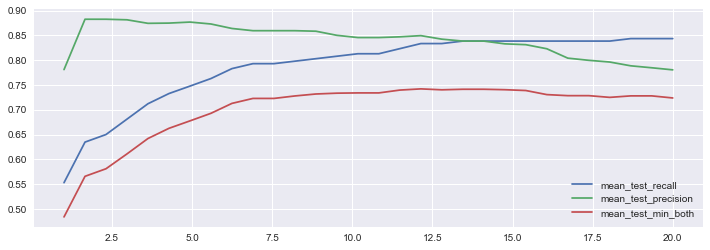

In [11]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']], 
             df_results[score], 
             label=score)
plt.legend();

And here's the train metrics.

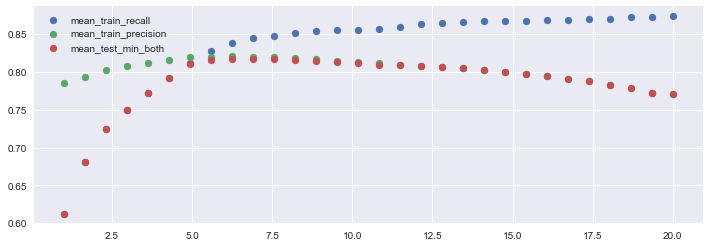

In [12]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall', 'mean_train_precision', 'mean_test_min_both']:
    plt.scatter(x=[_[1] for _ in df_results['param_class_weight']], 
                y=df_results[score.replace('test', 'train')], 
                label=score)
plt.legend();

# Using Outlier Detection Models

In [13]:
mod = IsolationForest().fit(X)
np.where(mod.predict(X) == -1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

And now in a gridsearch.

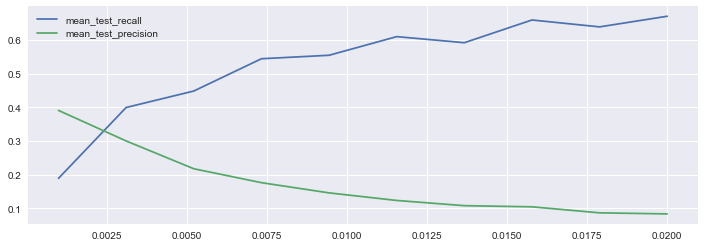

In [14]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1, 0))

grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision, 
             'recall': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)
grid.fit(X, y);

plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'], 
             df_results[score], 
             label=score)
plt.legend();

<br><br><br><br><br><br><br><br><br><br><br><br>

In [15]:
df = pd.DataFrame(grid.cv_results_)
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_recall'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_precision']);

KeyError: 'param_class_weight'

In [ ]:
def min_pre_rec(y, y_true):
    return min(recall_score(y, y_true), precision_score(y, y_true))

In [ ]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == 1, 0, 1))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == 1, 0, 1))

In [ ]:
grid = GridSearchCV(
    estimator=LogisticRegression(class_weight=10),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 40, t5)]},
    scoring={'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'min_pre_rec': make_scorer(min_pre_rec)},
    refit='precision',
    cv = 10,
    n_jobs=-1
)
grid.fit(X, y)

In [ ]:
df = pd.DataFrame(grid.cv_results_)
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_recall'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_precision'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_min_pre_rec']);

In [ ]:
_ = make_scorer(recall_score)

In [ ]:
import numpy as np 

np.eye(4)

In [ ]:
1 + 1